In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


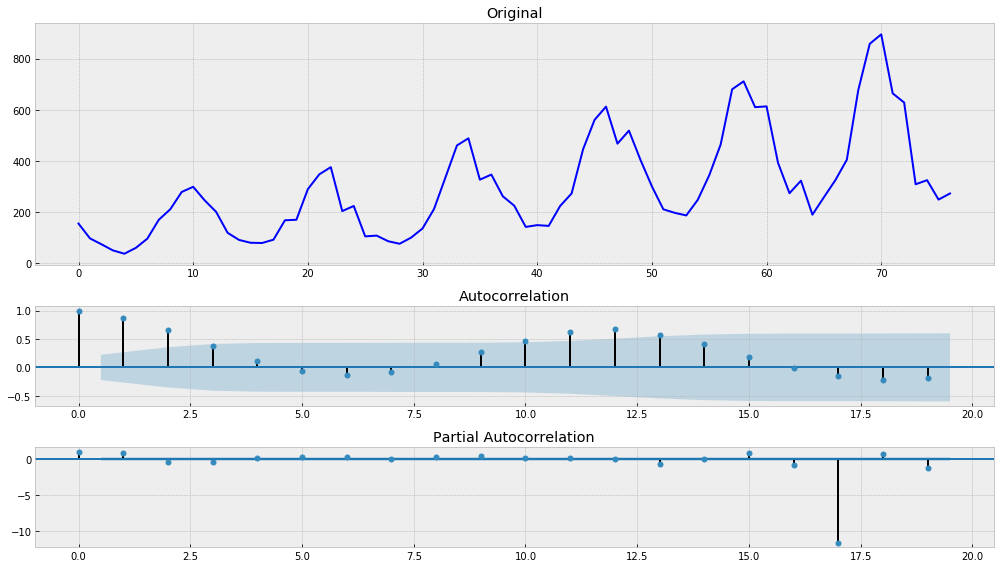

In [9]:
series1 = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")['Count']
tsplot(series1)

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


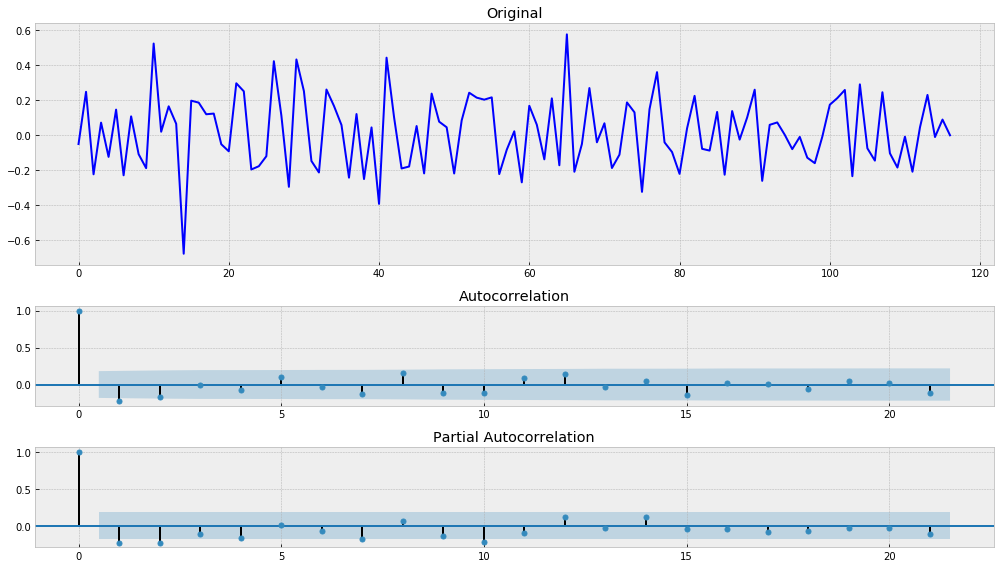

In [13]:
series2 = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")['Count']
series2 = boxcox(series2, 0)
series2 = np.diff(series2, 1)
tsplot(series2)


# Скользящее среднее

In [5]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

Скользящее среднее на нестационарном ряде

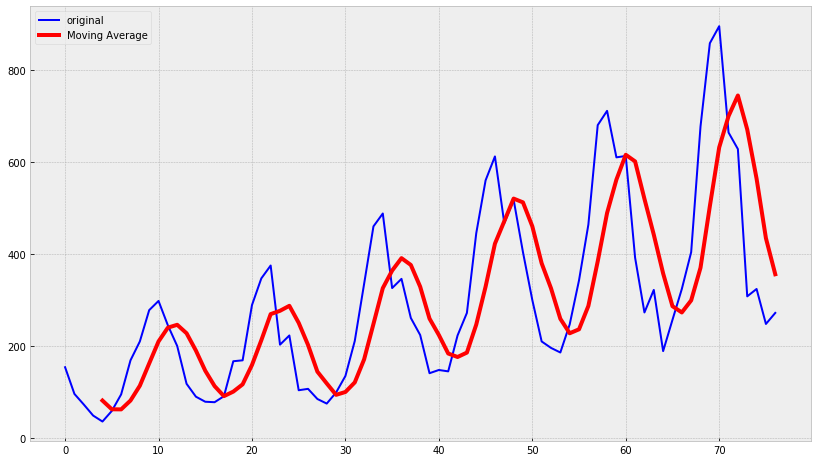

In [24]:
ser = moving_average(series1, 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Скользящее среднее на стационарном ряде

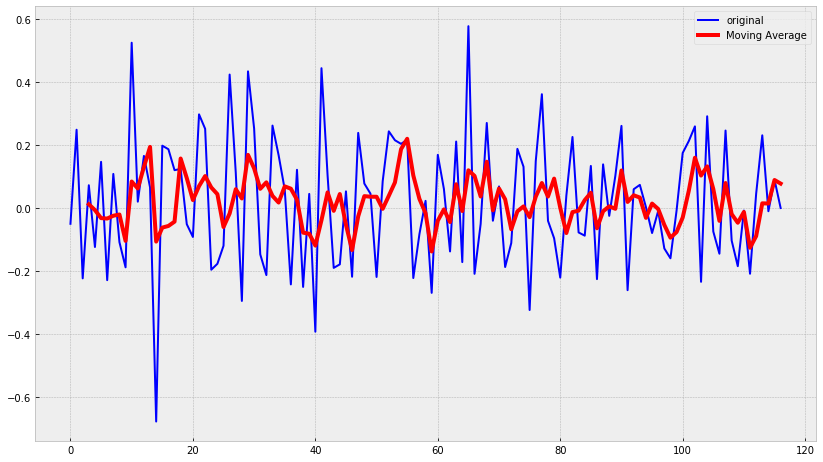

In [23]:
ser = moving_average(series2, 4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Реальные значения сильно отличаются от предсказанных. 
Минус метода в невозможности использовать для предсказаний. Но можно получить тренд используя большое окно.

# Взвешенная скользящая средняя

In [25]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

Взвешенная скользящая среднее на нестационарном ряде

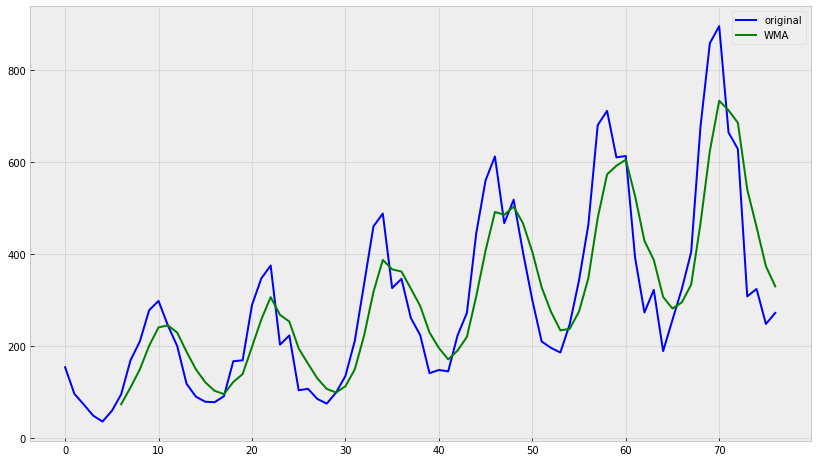

In [27]:
wma = weighted_moving_average(series1, 7, [1,1,2,3,5,8,13])
ma = moving_average(series1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
#     plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Взвешенная скользящая среднее на стационарном ряде

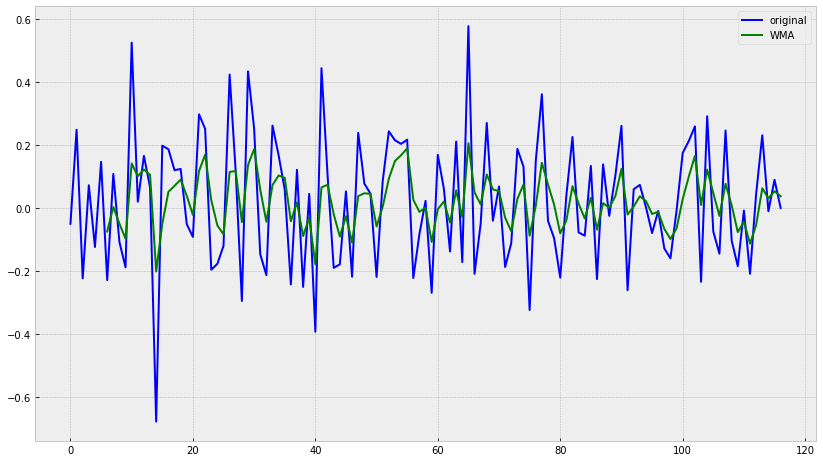

In [39]:
wma = weighted_moving_average(series2, 7, [1,1,2,3,5,8,13])
# ma = moving_average(series2, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
#     plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Результат лучше, но еще не достаточно качественные предсвказания.

# Экспоненциальное сглаживание

In [29]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

Экспоненциальное сглаживание на нестационарном ряде

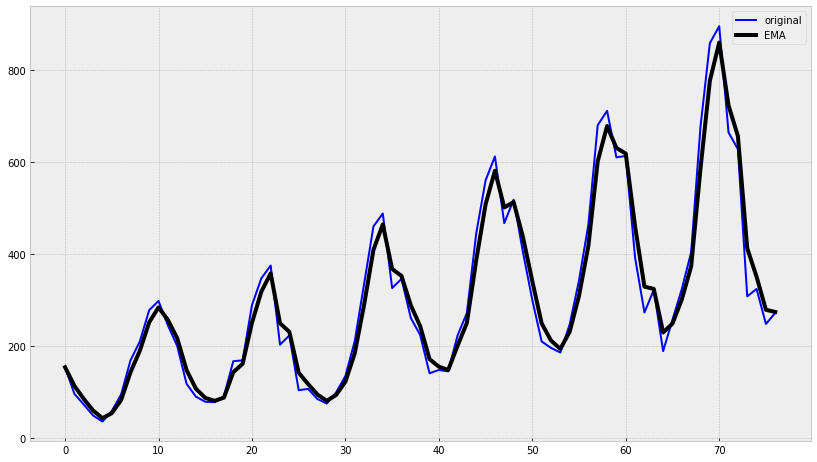

In [34]:
ema = exponential_moving_average(series1, 0.7)
# wma = weighted_moving_average(series1, 7, [1,1,2,3,5,8,13])
# ma = moving_average(series1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series1, color='blue',label='original')
#     plt.plot(ma, color='red', linewidth='2', label='MA')
#     plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Экспоненциальное сглаживание на стационарном ряде

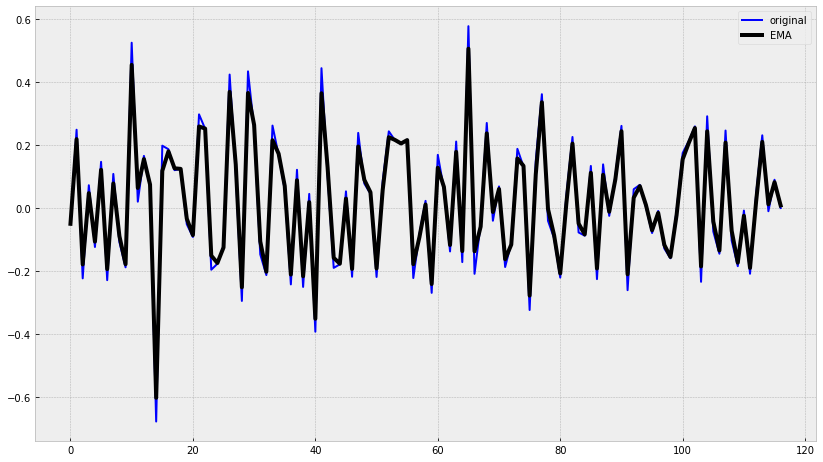

In [75]:
ema = exponential_moving_average(series2, 0.9)
# wma = weighted_moving_average(series1, 7, [1,1,2,3,5,8,13])
# ma = moving_average(series1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series2, color='blue',label='original')
#     plt.plot(ma, color='red', linewidth='2', label='MA')
#     plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Прогнозируемые значения уже достаточно близки к реальным.



# Двойное экспоненциальное сглаживание

In [40]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

Двойное экспоненциальное сглаживание на нестационарном ряде

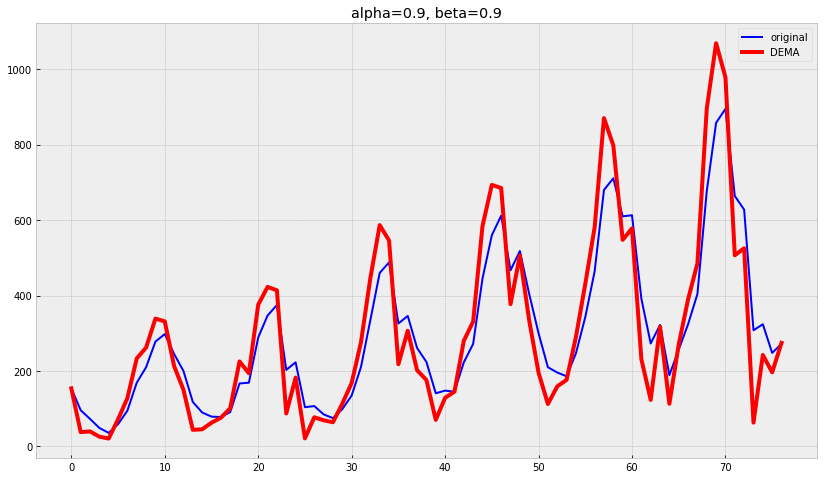

In [96]:
def plot_dema_1(alpha, beta):
    dema = double_ema(series1, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series1, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()
plot_dema_1(0.9, 0.9)

Двойное экспоненциальное сглаживание на стационарном ряде

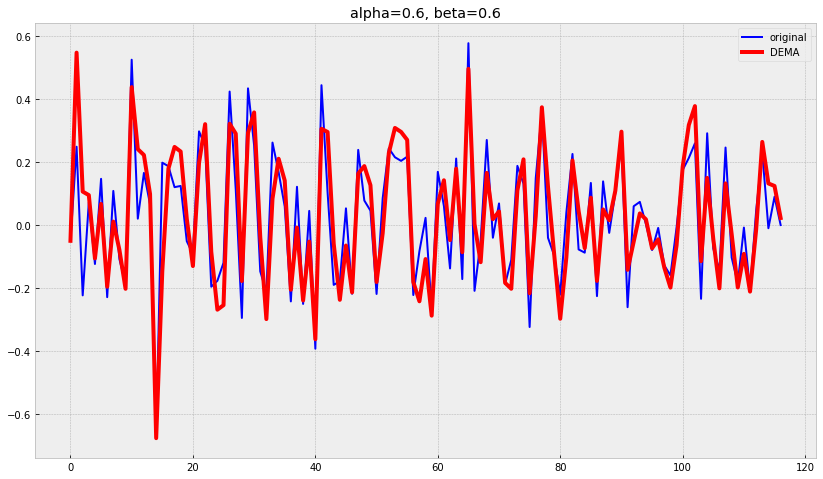

In [95]:
def plot_dema_2(alpha, beta):
    dema = double_ema(series2, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series2, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()
plot_dema_2(0.6, 0.6)

Требуется подбирать парметры, могут сильно отличаться результаты в взависимости от параметров.

# Хольт-Винтерс

In [50]:
def initial_trend(series, season_len):
    i = 0
    return sum([float(series[i + season_len] - series[i]) / season_len])

In [51]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [52]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

Хольт-Винтерс на нестационарном ряде

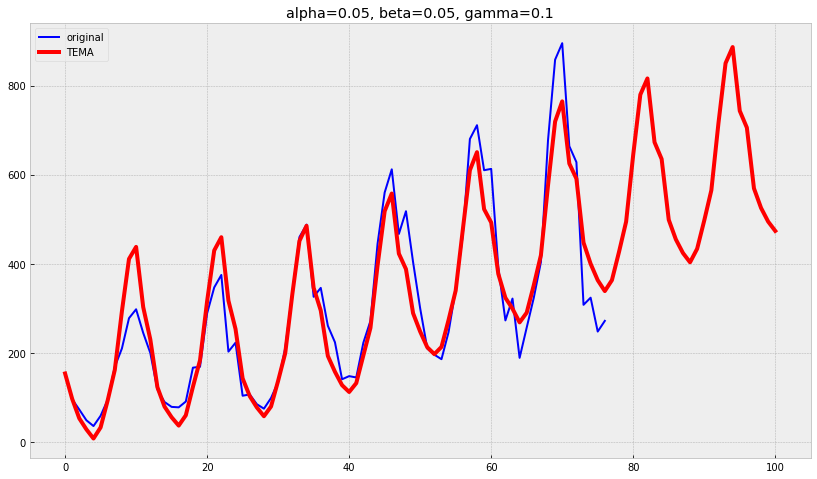

In [60]:
def plot_tema(alpha, beta, gamma, ser=series1, ser_to_plot=series1, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
plot_tema(0.05, 0.05, 0.1)

Хольт-Винтерс на стационарном ряде

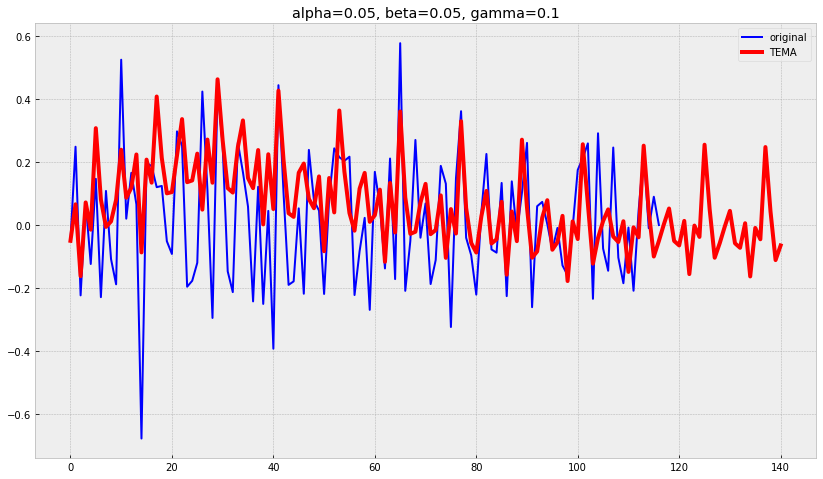

In [61]:
def plot_tema(alpha, beta, gamma, ser=series2, ser_to_plot=series2, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
plot_tema(0.05, 0.05, 0.1)

Довольно не плохой результат, но все равно требуется подбор параметров. 

# Подбор параметров

In [62]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [63]:
series = series1

In [64]:
train, test, val = series[:60], series[60:70], series[70:]

In [65]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [66]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

      fun: 13337.149611111166
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([86562.85226607,     0.        ,  5853.8529629 ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([0., 0., 0.])


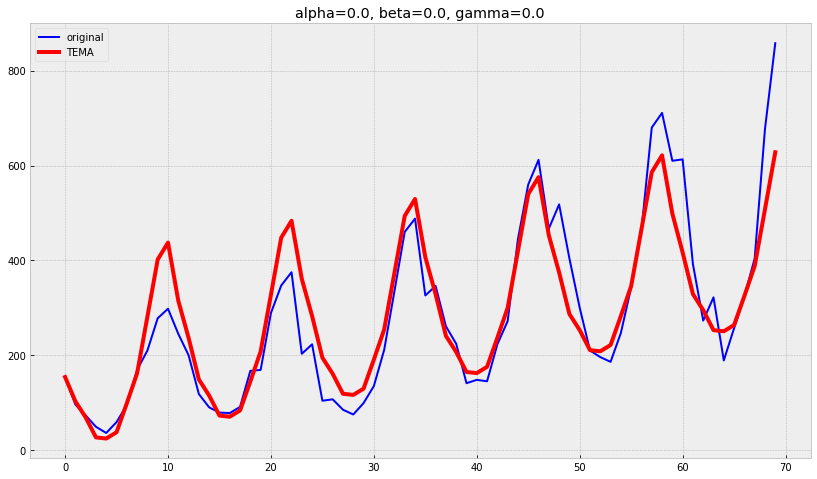

In [67]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

In [68]:
series2 = series2

      fun: 0.08539041595883243
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01639208,  2.16519141,  0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([1., 0., 1.])


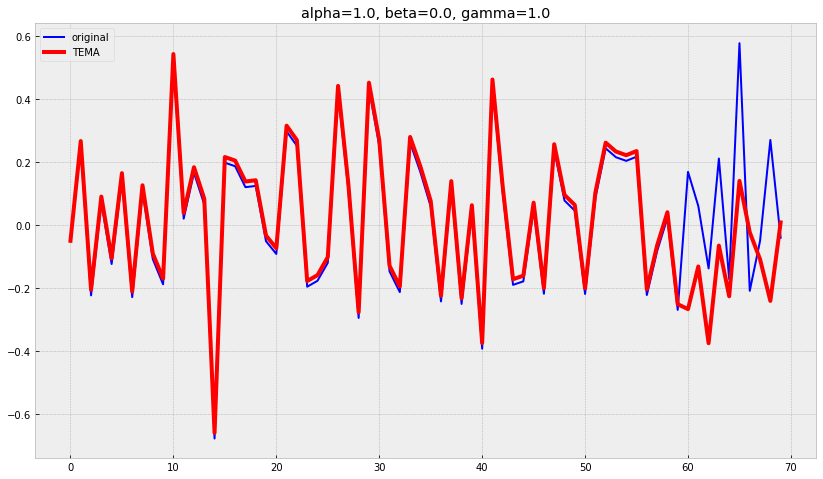

In [71]:
train, test, val = series2[:60], series2[60:70], series2[70:]
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series2[:70], n_preds=len(test))